In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [115]:
!pip install --upgrade tensorflow-model-optimization



  Attempting uninstall: absl-py
    Found existing installation: absl-py 2.3.0
    Uninstalling absl-py-2.3.0:
      Successfully uninstalled absl-py-2.3.0


# Import all the Dependencies


In [125]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# CONSTANT

In [3]:
BATCHSIZE = 32
IMAGESIZE = 256
CHANNELS = 3
EPOCHES = 45


#  Reading and Partitioning the Dataset

In [15]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed = 123,
    image_size = (IMAGESIZE ,IMAGESIZE),
    batch_size = BATCHSIZE,
    shuffle = True,

    
)


Found 2152 files belonging to 3 classes.


# Checking the Available Classes


In [17]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [23]:
for image_batch, lables_batch in dataset.take(1):
    print(image_batch.shape)
    print(lables_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 2, 1, 0, 1, 1, 1, 0, 0, 0])>>


# PLOTING 


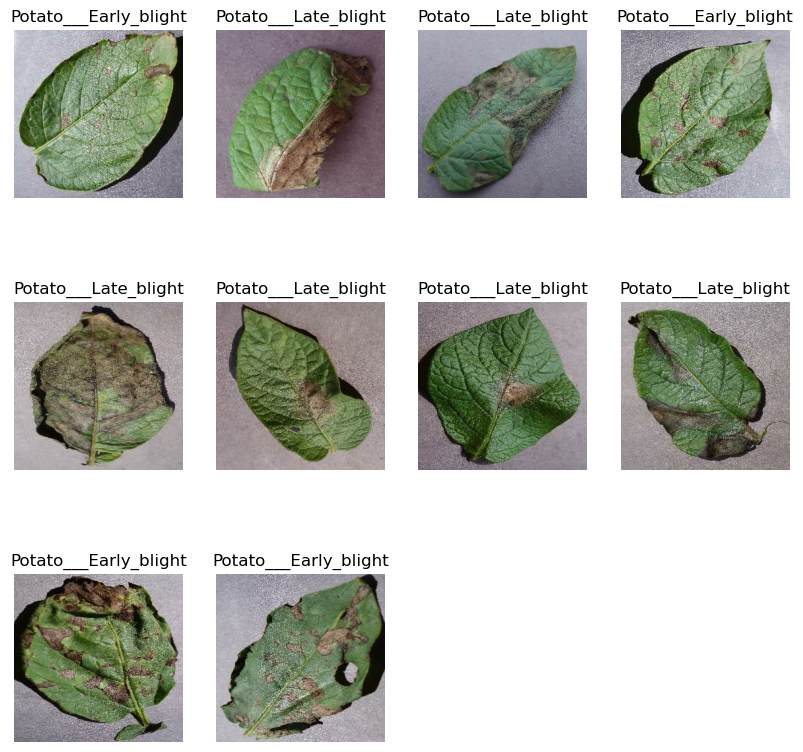

In [51]:
plt.figure(figsize=(10,10))
for image_batch,lables_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[lables_batch[i]])
        plt.axis("off")

# Initializing, Exploring & Partioning the Dataset
## Function to Split Dataset

In [81]:
def image_partition(ds , train_split=0.8  ,val_split=0.1 ,test_split=0.1 ,shuffle=True,shuffle_size=10000):
    assert(train_split+test_split+val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed=10)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
        


    return train_ds ,val_ds,test_ds

In [83]:
train_ds , val_ds , test_ds  = image_partition(dataset)

In [85]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


# Cache and Prefetch

In [95]:
from tensorflow.data import AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

 # resize_and_rescale

In [133]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGESIZE, IMAGESIZE),
    layers.Rescaling(1.0/255)
])


# Data Augmentation

In [135]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("vertical and horizontal"),
    layers.RandomRotation(0.2),
            
    

    
    
])

In [159]:
from tensorflow.keras import backend as K

input_shape = (IMAGESIZE, IMAGESIZE, CHANNELS)
batch_input_shape = (BATCHSIZE, IMAGESIZE, IMAGESIZE, CHANNELS)
chanDim = -1

if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGESIZE, IMAGESIZE)
    batch_input_shape = (BATCHSIZE, CHANNELS, IMAGESIZE, IMAGESIZE)
    chanDim = 1


# Model Buiding


In [ ]:
input_shape =(BATCHSIZE, IMAGESIZE, IMAGESIZE, CHANNELS)

n_class = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3) ,activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3) ,activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3) ,activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3) ,activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3) ,activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3) ,activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64 ,activation ="relu"),
    layers.Dense(64 , activation = "softmax"),
])

model.build(input_shape=input_shape)

# Compiling the Model


### i use adam optimzer and  SparseCategoricalCrossentropy

In [183]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = False),
    metrics = ["accuracy"],
)

# Training the Network

In [191]:
history = model.fit(
    train_ds,
    batch_size = BATCHSIZE,
    validation_data = val_ds,
    epochs = EPOCHES,
    verbose=1,
)

Epoch 1/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4345 - loss: 2.0433 - val_accuracy: 0.5729 - val_loss: 0.8791
Epoch 2/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6597 - loss: 0.7856 - val_accuracy: 0.6094 - val_loss: 0.7734
Epoch 3/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7833 - loss: 0.5291 - val_accuracy: 0.7708 - val_loss: 0.6043
Epoch 4/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8070 - loss: 0.4655 - val_accuracy: 0.8125 - val_loss: 0.4001
Epoch 5/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8850 - loss: 0.2749 - val_accuracy: 0.9115 - val_loss: 0.2176
Epoch 6/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9136 - loss: 0.2142 - val_accuracy: 0.9115 - val_loss: 0.2117
Epoch 7/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9240 - loss: 0.1989 - val_accuracy: 0.9115 - val_loss: 0.2238
Epoch 8/45
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9341 - loss: 0.1790 - val_accuracy: 0.9323 - val_

# Testing the Model

In [195]:
print("[INFO] Calculating model accuracy")
score = model.evaluate(test_ds)
print(f"Test Accuracy: {round(score[1],4)*100}%")


[INFO] Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 533ms/step - accuracy: 1.0000 - loss: 0.0142
Test Accuracy: 100.0%


In [197]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


NameError: name 'class_names' is not defined

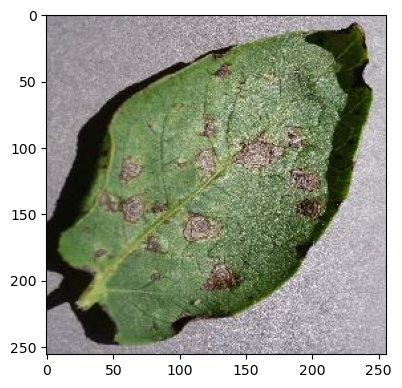

In [205]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [217]:
model.save(r"C:\CODE\Potato_Project\Training\models\potato_model.h5")
